In [2]:
import scipy.io as sio
import numpy as np

In [3]:
def mat2dict(filename):
    """Converts MoVi mat files to a python nested dictionary.
    This makes a cleaner representation compared to sio.loadmat
    Arguments:
        filename {str} -- The path pointing to the .mat file which contains
        MoVi style mat structs
    Returns:
        dict -- A nested dictionary similar to the MoVi style MATLAB struct
    """
    # Reading MATLAB file
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)

    # Converting mat-objects to a dictionary
    for key in data:
        if key != "__header__" and key != "__global__" and key != "__version__":
            if isinstance(data[key], sio.matlab.mio5_params.mat_struct):
                data_out = matobj2dict(data[key])
    return data_out


def matobj2dict(matobj):
    """A recursive function which converts nested mat object
    to a nested python dictionaries

    Arguments:
        matobj {sio.matlab.mio5_params.mat_struct} -- nested mat object

    Returns:
        dict -- a nested dictionary
    """
    ndict = {}
    for fieldname in matobj._fieldnames:
        attr = matobj.__dict__[fieldname]
        if isinstance(attr, sio.matlab.mio5_params.mat_struct):
            ndict[fieldname] = matobj2dict(attr)
        elif isinstance(attr, np.ndarray) and fieldname == "move":
            for ind, val in np.ndenumerate(attr):
                ndict[
                    fieldname
                    + str(ind).replace(",", "").replace(")", "").replace("(", "_")
                ] = matobj2dict(val)
        elif fieldname == "skel":
            tree = []
            for ind in range(len(attr)):
                tree.append(matobj2dict(attr[ind]))
            ndict[fieldname] = tree
        else:
            ndict[fieldname] = attr
    return ndict



In [4]:
data = mat2dict('../data/AMASS/F_amass_Subject_1.mat')
len(data['move_0']['jointsLocation_amass'])

581

In [37]:
joints = data['move_0']['jointsLocation_amass']
joints, joints.shape

(array([[[373.28643049, 256.40073867, 955.47778345],
         [353.75470365, 317.86515453, 870.13708985],
         [365.54407025, 191.33526721, 861.75640858],
         ...,
         [429.23064972,   1.58622005, 856.33614845],
         [437.15028907,  22.95146027, 833.58482457],
         [447.49312545,  32.03620651, 809.49361808]],
 
        [[373.3180504 , 256.39192671, 955.4722096 ],
         [353.89069129, 317.74728843, 870.02929031],
         [365.95113982, 191.23400845, 861.78480937],
         ...,
         [429.87706174,   1.62017443, 856.28778591],
         [437.81494011,  23.0745832 , 833.62691208],
         [448.18567146,  32.2550694 , 809.58403751]],
 
        [[372.84393154, 256.30762238, 955.53079525],
         [353.42551314, 317.66275313, 870.08567431],
         [365.47417485, 191.14811715, 861.84471378],
         ...,
         [429.38458465,   1.55661251, 856.32733533],
         [437.31873773,  23.01660921, 833.67045501],
         [447.68860482,  32.20348801, 809.62964424]

In [54]:
# markers(1:4:end,:,:);
markers = joints[0::4,:,:]
markers.shape

(146, 52, 3)

In [53]:
# Validation
import scipy.io as sio
markers_matlab = sio.loadmat('/home/ugnelis/GIT/MoVi/chark/MoVi-Toolbox/MoCap/Markers.mat', simplify_cells=True)['Markers']
markers_matlab.shape

(146, 52, 3)

In [50]:
# For some reason number after comma don't match
markers[0, 3, 0], markers_matlab[0, 3, 0]

(328.662936338117, 328.6629512392782)

In [23]:
import cv2
import matplotlib
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('../data/PG1/F_PG1_Subject_1_L1.avi')
cap.isOpened()
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)

146


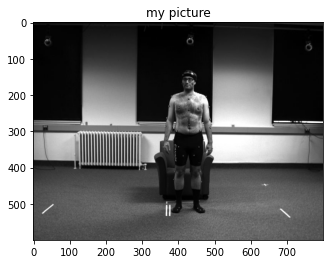

In [9]:
total_frames = cap.get(0)
ret, frame = cap.read()

plt.imshow(frame)
plt.title('my picture')
plt.show()

In [10]:
camera_data = np.load('../data/Calib/cameraParams_PG1.npz')
for key in camera_data.files:
    print(key)

IntrinsicMatrix
RadialDistortion


In [12]:
intrinsic_matrix = camera_data['IntrinsicMatrix']
# intrinsic_matrix = np.rot90(np.fliplr(intrinsic_matrix))
print(intrinsic_matrix)

# fx = intrinsic_matrix[0][0]
# fy = intrinsic_matrix[1][1]
# cx = intrinsic_matrix[2][0]
# cy = intrinsic_matrix[2][1]

[[979.17889011   0.           0.        ]
 [  0.         978.10179305   0.        ]
 [408.0273103  291.16967878   1.        ]]


In [13]:
radial_distortion = camera_data['RadialDistortion']
radial_distortion

array([-0.18236467,  0.18388686])

In [14]:
extrinsics_data = np.load('../data/Calib/Extrinsics_PG1.npz')
for key in extrinsics_data.files:
    print(key)

rotation_matrix = extrinsics_data['rotationMatrix']
translation_vector = extrinsics_data['translationVector']
rotation_matrix, translation_vector

rotationMatrix
translationVector


(array([[ 0.0305191 ,  0.06318672, -0.99753497],
        [ 0.99942183,  0.01303452,  0.03140247],
        [ 0.01498661, -0.9979166 , -0.06275239]]),
 array([-177.23154422, 1030.55751095, 4999.31781498]))

https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

In [ ]:
translation_vector_expand = np.expand_dims(translation_vector, axis=1)
translation_vector_expand

In [ ]:
def worldToVideo(mdData, cameraParams, rotationMatrix, translationVector):
    markers = mdData[0::4,:,:]
    return 123
    

In [ ]:
# def worldToImage(rotationMatrix, translationVector, worldPoints, varargin)


In [20]:
# def worldToImage(rotationMatrix, translationVector, worldPoints, varargin)


array([[-177.23154422],
       [1030.55751095],
       [4999.31781498]])

In [ ]:
def worldToVideo(mdData, cameraParams, rotationMatrix, translationVector):
    markers = mdData[0::4,:,:]
    return 123
    

In [ ]:
# def worldToImage(rotationMatrix, translationVector, worldPoints, varargin)
